In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras import layers, models
import math
import matplotlib.pyplot as plt

base_path = "/content/drive/MyDrive/CIC-IDS/CIC-IDS-2017/Dataset/CIC-IDS-2017/CSVs/MachineLearningCSV/MachineLearningCVE"

csv_files = [
    "Monday-WorkingHours.pcap_ISCX.csv",
    "Tuesday-WorkingHours.pcap_ISCX.csv",
    "Wednesday-workingHours.pcap_ISCX.csv",
    "Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv",
    "Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv",
    "Friday-WorkingHours-Morning.pcap_ISCX.csv",
    "Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv",
    "Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv"
]

dfs = [pd.read_csv(os.path.join(base_path, f)) for f in csv_files]
data = pd.concat(dfs, ignore_index=True)
data.columns = data.columns.str.strip()

data = data.replace([np.inf, -np.inf], np.nan)
data = data.dropna()

def map_label(l):
    l = str(l).strip()
    if l == "BENIGN": return "Benign"
    if "DoS" in l or "DDoS" in l: return "DoS/DDoS"
    if "PortScan" in l: return "PortScan"
    if "Patator" in l or "Brute Force" in l: return "Brute Force"
    if "Web Attack" in l: return "Web Attacks"
    return None

data["Class"] = data["Label"].apply(map_label)
data = data[data["Class"].notna()]

MAX_SAMPLES_PER_CLASS = 60000

sampled_data = []
for cls in data["Class"].unique():
    df_cls = data[data["Class"] == cls]
    if len(df_cls) > MAX_SAMPLES_PER_CLASS:
        df_cls = df_cls.sample(MAX_SAMPLES_PER_CLASS, random_state=42)
    sampled_data.append(df_cls)

data = pd.concat(sampled_data, ignore_index=True)

cols_to_drop = ["Label", "Timestamp", "Flow ID", "Source IP",
                "Destination IP", "Source Port", "Destination Port", "Protocol"]

for c in cols_to_drop:
    if c in data.columns:
        data = data.drop(columns=[c])

X = data.select_dtypes(include=["float64", "int64"])
y = data["Class"]

X = X.replace([np.inf, -np.inf], np.nan)
mask = X.notna().all(axis=1)
X = X[mask]
y = y[mask]

le = LabelEncoder()
y_enc = le.fit_transform(y)
num_classes = len(le.classes_)

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y_enc, test_size=0.30, random_state=42, stratify=y_enc
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_val_s   = scaler.transform(X_val)
X_test_s  = scaler.transform(X_test)

In [ ]:
kmeans = KMeans(n_clusters=num_classes, random_state=42, n_init=20)
kmeans.fit(X_train_s)

def kmeans_proba(km, X):
    dists = km.transform(X)

    dists_neg = -dists
    dists_neg -= dists_neg.max(axis=1, keepdims=True)
    exp_neg = np.exp(dists_neg)
    proba = exp_neg / exp_neg.sum(axis=1, keepdims=True)
    return proba

km_train_proba = kmeans_proba(kmeans, X_train_s)
km_val_proba   = kmeans_proba(kmeans, X_val_s)
km_test_proba  = kmeans_proba(kmeans, X_test_s)

X_train_km = np.concatenate([X_train_s, km_train_proba], axis=1)
X_val_km   = np.concatenate([X_val_s,   km_val_proba],   axis=1)
X_test_km  = np.concatenate([X_test_s,  km_test_proba],  axis=1)

input_dim_km = X_train_km.shape[1]

def build_cldnn(input_dim, num_classes):
    m = models.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(), layers.Dropout(0.3),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(), layers.Dropout(0.3),
        layers.Dense(64, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    m.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
    return m

def build_1d_cnn(input_dim, num_classes):
    m = models.Sequential([
        layers.Reshape((input_dim, 1)),
        layers.Conv1D(64, 3, activation='relu'),
        layers.MaxPooling1D(2),
        layers.Conv1D(128, 3, activation='relu'),
        layers.GlobalMaxPooling1D(),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    m.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
    return m

def build_cnn(input_dim, num_classes):
    side = int(math.ceil(math.sqrt(input_dim)))
    pad = side*side - input_dim
    m = models.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Lambda(lambda x: tf.pad(x, [[0,0],[0,pad]])),
        layers.Reshape((side, side, 1)),
        layers.Conv2D(32, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.GlobalMaxPooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    m.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
    return m

def build_cnn_lstm(input_dim, num_classes):
    m = models.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Reshape((input_dim, 1)),
        layers.Conv1D(32, kernel_size=3, activation='relu'),
        layers.MaxPooling1D(pool_size=2),
        layers.LSTM(64),
        layers.Dense(64, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    m.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
    return m

In [ ]:
def run(model, name, X_tr, X_v, X_te):
    print(f"\n===== {name} =====")
    history = model.fit(
        X_tr, y_train,
        validation_data=(X_v, y_val),
        epochs=5,
        batch_size=64,
        verbose=1
    )

    val_acc  = history.history["val_accuracy"][-1]
    val_loss = history.history["val_loss"][-1]
    print(f"Validation Accuracy: {val_acc:.6f}")
    print(f"Validation Loss:     {val_loss:.6f}")

    loss, acc = model.evaluate(X_te, y_test, verbose=0)
    print(f"Test Accuracy:       {acc:.6f}")
    print(f"Test Loss:           {loss:.6f}")

    preds = model.predict(X_te).argmax(axis=1)

    print(classification_report(
        y_test,
        preds,
        target_names=le.classes_,
        digits=6
    ))
    print("Confusion:\n", confusion_matrix(y_test, preds))

    return history, preds, acc

In [ ]:
accuracies = []
model_names = []

cldnn_km = build_cldnn(input_dim_km, num_classes)
hist_km_cldnn, preds_km_cldnn, acc_km_cldnn = run(
    cldnn_km, "K-MEANS + ClDNN", X_train_km, X_val_km, X_test_km
)
accuracies.append(acc_km_cldnn); model_names.append("K-MEANS + ClDNN")

cnn1d_km = build_1d_cnn(input_dim_km, num_classes)
hist_km_1dcnn, preds_km_1dcnn, acc_km_1dcnn = run(
    cnn1d_km, "K-MEANS + 1D-CNN", X_train_km, X_val_km, X_test_km
)
accuracies.append(acc_km_1dcnn); model_names.append("K-MEANS + 1D-CNN")

cnn_km = build_cnn(input_dim_km, num_classes)
hist_km_cnn, preds_km_cnn, acc_km_cnn = run(
    cnn_km, "K-MEANS + CNN", X_train_km, X_val_km, X_test_km
)
accuracies.append(acc_km_cnn); model_names.append("K-MEANS + CNN")

cnnlstm_km = build_cnn_lstm(input_dim_km, num_classes)
hist_km_cnnlstm, preds_km_cnnlstm, acc_km_cnnlstm = run(
    cnnlstm_km, "K-MEANS + CNN-LSTM", X_train_km, X_val_km, X_test_km
)
accuracies.append(acc_km_cnnlstm); model_names.append("K-MEANS + CNN-LSTM")


===== K-MEANS + ClDNN =====
Epoch 1/5
2144/2144 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.9053 - loss: 0.2549 - val_accuracy: 0.9566 - val_loss: 0.1174
Epoch 2/5
2144/2144 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9524 - loss: 0.1248 - val_accuracy: 0.9653 - val_loss: 0.1035
Epoch 3/5
2144/2144 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9601 - loss: 0.1091 - val_accuracy: 0.9635 - val_loss: 0.1079
Epoch 4/5
2144/2144 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9614 - loss: 0.1050 - val_accuracy: 0.9668 - val_loss: 0.0923
Epoch 5/5
2144/2144 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9643 - loss: 0.0975 - val_accuracy: 0.9691 - val_loss: 0.0908
Validation Accuracy: 0.969118
Validation Loss:     0.090757
Test Accuracy:       0.969526
Test Loss:           0.089843
919/919 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
              precision    recall  f1-score   support

      Benign   0.979023  0.933444  0.955691      9000
 Brute Force   0.892784  0.940895  0.916208      2301
 

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


2144/2144 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - accuracy: 0.8606 - loss: 0.4006 - val_accuracy: 0.9476 - val_loss: 0.1451
Epoch 2/5
2144/2144 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9473 - loss: 0.1425 - val_accuracy: 0.9586 - val_loss: 0.1232
Epoch 3/5
2144/2144 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9587 - loss: 0.1157 - val_accuracy: 0.9649 - val_loss: 0.1011
Epoch 4/5
2144/2144 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9626 - loss: 0.1070 - val_accuracy: 0.9682 - val_loss: 0.0952
Epoch 5/5
2144/2144 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9640 - loss: 0.1032 - val_accuracy: 0.9701 - val_loss: 0.0913
Validation Accuracy: 0.970104
Validation Loss:     0.091335
Test Accuracy:       0.969492
Test Loss:           0.090615
919/919 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
              precision    recall  f1-score   support

      Benign   0.979718  0.933889  0.956255      9000
 Brute Force   0.909516  0.930465  0.919871      2301
    DoS/DDoS   0.960608  0.997111  0.978

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


2144/2144 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.8838 - loss: 0.3156 - val_accuracy: 0.9512 - val_loss: 0.1308
Epoch 2/5
2144/2144 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9524 - loss: 0.1283 - val_accuracy: 0.9393 - val_loss: 0.1344
Epoch 3/5
2144/2144 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9595 - loss: 0.1090 - val_accuracy: 0.9635 - val_loss: 0.1028
Epoch 4/5
2144/2144 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9643 - loss: 0.0979 - val_accuracy: 0.9683 - val_loss: 0.0901
Epoch 5/5
2144/2144 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9666 - loss: 0.0953 - val_accuracy: 0.9698 - val_loss: 0.0885
Validation Accuracy: 0.969764
Validation Loss:     0.088508
Test Accuracy:       0.968880
Test Loss:           0.088570
919/919 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
              precision    recall  f1-score   support

      Benign   0.983502  0.927333  0.954592      9000
 Brute Force   0.863724  0.977836  0.917244      2301
    DoS/DDoS   0.970245  0.989111  0.979

/tmp/ipython-input-2209906612.py:6: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.ylim(1.0, 1.0)


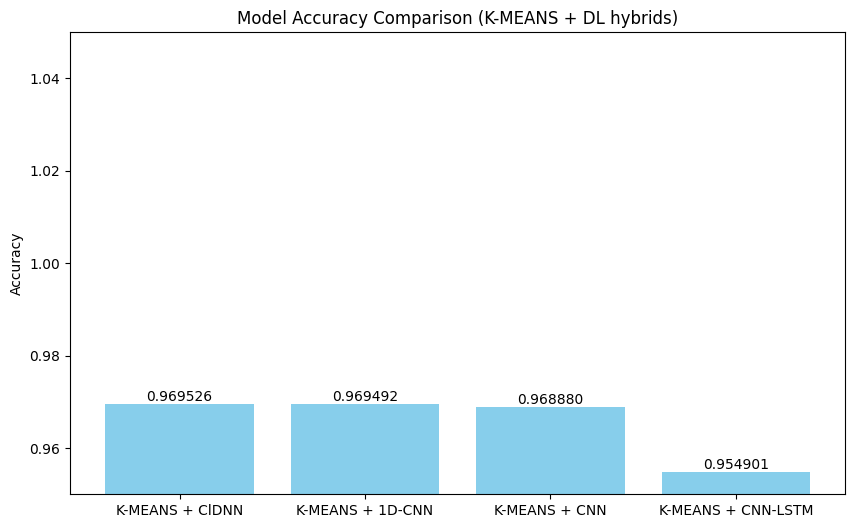

In [ ]:
plt.figure(figsize=(10,6))
plt.bar(model_names, accuracies, color='skyblue')
plt.ylim(1.0, 1.0)
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison (K-MEANS + DL hybrids)")

for i, acc in enumerate(accuracies):
    plt.text(i, acc, f"{acc:.6f}", ha='center', va='bottom')

plt.show()